In [5]:
!python models/models.py Datasets/datasets.py Datasets/audio_utils.py

In [15]:
import sys
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
#import panns_inference

TUT_CSV = 'Datasets/TUT18_train.csv'
SCAPPER_TRAIN_CSV = 'Datasets/scrapper_train_dataset.csv'
SCAPPER_TEST_CSV = 'Datasets/scrapper_test_dataset.csv'
TUT_AUD_DIR = '../audioData/TUTUrban2018/developmentDataset/TUT-urban-acoustic-scenes-2018-development/'
SCAPPER_AUD_DIR = '../audioData/sythenticSoundscenes/train/'

In [16]:
scapper_df = pd.read_csv(SCAPPER_TRAIN_CSV)
scapper_scene_labels = (list)(scapper_df['acoustic_scene_label'].unique())
tut_df = pd.read_csv(TUT_CSV)
tut_scene_labels = (list)(tut_df['labels'].unique())

In [10]:
sys.path.append('Datasets/')
sys.path.append('utils/')
sys.path.append('models/')
import datasets
import audio_utils
import models

scapper_dataset = datasets.scraperDataset(SCAPPER_TRAIN_CSV, SCAPPER_AUD_DIR, only_scene=False, transforms=audio_utils.get_log_melSpectrogram)
#tut_dataset = datasets.TUT18_Dataset(TUT_CSV, TUT_AUD_DIR, transforms=audio_utils.get_log_melSpectrogram)

In [17]:
from torch.utils.data import DataLoader

#train_loader = DataLoader(tut_dataset, batch_size=32, shuffle=True)
train_loader = DataLoader(scapper_dataset, batch_size=32, shuffle=True)

for i, batch in enumerate(train_loader):
    if i == 0:
        print((batch['data'].shape))
    else:
        break

torch.Size([32, 1, 40, 1501])


In [18]:
def null_features(batch, index=2):
    for i in range(batch.shape[0]):
        batch[i][0][index] = torch.ones(batch[i][0][index].shape)*batch[i].min()
    
    return batch

In [20]:
model = models.ASC_Model00(return_second_last=False)
#model.load_state_dict(torch.load('ASC_Model00_TUT18_20epochs_00_statedict.pt'))
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
for i in range(len(tut_df['files'])): 
    if tut_df['files'][i].split('.')[1] != 'wav':
        print(tut_df['files'][i])

In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

epochs = 20

#for epoch in range(epochs):
    #model = models.train(model, device, train_loader, loss_fn, optimizer, epoch)

for epoch in range(epochs):
    running_loss = 0
    model.train()
    for i, batch in enumerate(train_loader):

        optimizer.zero_grad()
        inputs, labels = batch['data'], (batch['scene_label'])
        inputs = null_features(inputs).to(device)
        labels = labels.to(device = device, dtype=torch.float)

        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}')

Epoch 1, Loss: 2.3174478322901626
Epoch 2, Loss: 2.1967075213472893
Epoch 3, Loss: 2.060251409703113
Epoch 4, Loss: 1.9502236716290737
Epoch 5, Loss: 1.8269785807487813
Epoch 6, Loss: 1.706325183523462
Epoch 7, Loss: 1.5892905225145055
Epoch 8, Loss: 1.478473499734351
Epoch 9, Loss: 1.2587747206079198
Epoch 10, Loss: 1.1208637229939724
Epoch 11, Loss: 0.918648288605061
Epoch 12, Loss: 0.7853666150823553
Epoch 13, Loss: 0.7197153850438747
Epoch 14, Loss: 0.5474419416265285
Epoch 15, Loss: 0.5041563087638389
Epoch 16, Loss: 0.367726007793495
Epoch 17, Loss: 0.41254965509188934
Epoch 18, Loss: 0.26283645772553504
Epoch 19, Loss: 0.17447674971945742
Epoch 20, Loss: 0.16433962509828678


In [26]:
TUT_TEST_CSV = 'Datasets/TUT18_test.csv'
TUT_TEST_DF = pd.read_csv(TUT_TEST_CSV)

tut_test_dataset = datasets.TUT18_Dataset(TUT_TEST_CSV, TUT_AUD_DIR, transforms=audio_utils.get_log_melSpectrogram)
train_loader = DataLoader(tut_test_dataset, batch_size=32, shuffle=True)

In [27]:
from sklearn.metrics import accuracy_score, f1_score, precision_score

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

all_labels = []
all_predictions = []

model.eval()
with torch.inference_mode():
    for i, batch in enumerate(test_loader):
        inputs, labels = batch['data'], (batch['scene_label'])
        inputs = inputs.to(device)
        labels = labels.to(device = device, dtype=torch.float)
        outputs = model(inputs)

        outputs = (torch.sigmoid(outputs)).to(device = device, dtype=torch.float)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(outputs.cpu().numpy())

    '''print(accuracy_score(all_labels, all_predictions))
    print(f1_score(all_labels, all_predictions, average='macro'))
    print(precision_score(all_labels, all_predictions, average='macro'))'''

In [23]:
torch.save(model.state_dict(), 'ASC_Model00_scapper_20epochs_02Blacked_statedict.pt')

In [28]:
def convert_outputs(outputs):
    new_outputs = [0. for i in range(outputs.shape[0])]
    new_outputs[np.argmax(outputs)] = 1.
    return np.array(new_outputs)

    
for i in range(len(all_predictions)):
    all_predictions[i] = convert_outputs(all_predictions[i])

print(accuracy_score(all_labels, all_predictions))
print(f1_score(all_labels, all_predictions, average='macro'))
print(precision_score(all_labels, all_predictions, average='macro'))

0.7002613524991833
0.6954108397070791
0.7063995979497247


In [ ]:
'''ScapperDataset_ASC_0:
Accuracy: 0.8
F1: 0.7925053674044534
Precision: 0.822617791178798'''

'''TUT18Dataset_ASC_0 (20 epochs):
Accuracy: 0.7002613524991833
F1: 0.6954108397070791
Precision: 0.7063995979497247'''

In [29]:
labels_array = []
labels_preds = []

for i in range(len(all_labels)):
    labels_array.append(scapper_scene_labels[np.argmax(all_labels[i])])
    labels_preds.append(scapper_scene_labels[np.argmax(all_predictions[i])])

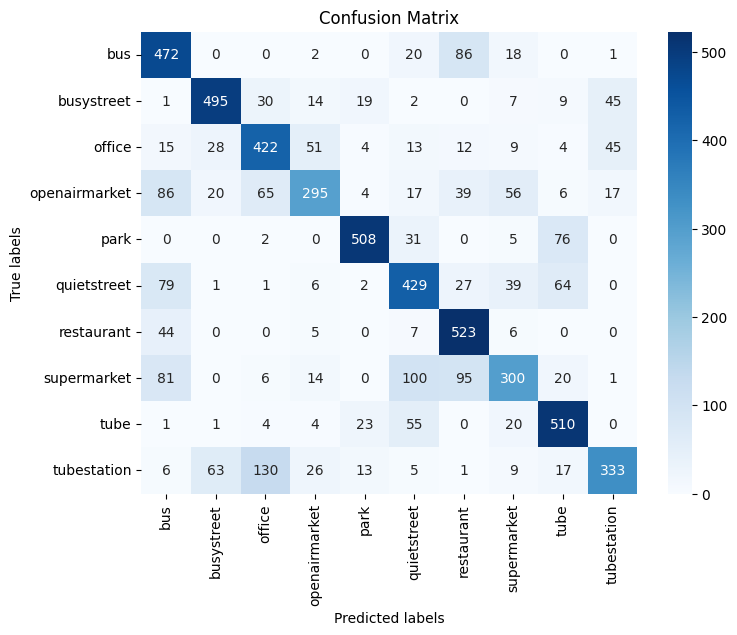

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(true_labels, predicted_labels, classes):
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

# Example usage:
classes = scapper_scene_labels


plot_confusion_matrix(labels_array, labels_preds, classes)

In [22]:
i = 2569
sample = os.path.join(SCAPPER_AUD_DIR, scapper_df['audio_fileNames'][i])
audio = audio_utils.load_audio_from_file(sample)
spec = audio_utils.get_log_melSpectrogram(audio)

model = model.cpu()
with torch.inference_mode():
    model.eval()
    output, second_last = model(spec.unsqueeze(0))
    print(output.shape)
    print(convert_outputs(torch.sigmoid(output)))
    #print(torch.argmax(output))

print(scapper_df['acoustic_scene_label'][i], scapper_scene_labels[torch.argmax(output)])


torch.Size([1, 10])
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
tube tube


In [18]:
torch.save(model.state_dict(), 'ASC_Model00_00_statedict.pt')

In [86]:
scapper_scene_labels

['bus',
 'busystreet',
 'office',
 'openairmarket',
 'park',
 'quietstreet',
 'restaurant',
 'supermarket',
 'tube',
 'tubestation']

In [20]:
for i in range(0,5):
    print(label_to_one_hot([scapper_dataset[i]['scene_label']]))

[[1 0 0 0 0 0 0 0 0 0]]
[[1 0 0 0 0 0 0 0 0 0]]
[[1 0 0 0 0 0 0 0 0 0]]
[[1 0 0 0 0 0 0 0 0 0]]
[[1 0 0 0 0 0 0 0 0 0]]
